## ransac registration and tissue detection for 10X visium - december 2021
### Version v1.0
### Author - Nadav Yayon, PhD
### Part of the ImageSpot toolbox package (unpublished)

In [2]:
# init 
import glob
import numpy as np
import os, sys, re
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import listdir
from os.path import isfile, join
from skimage.transform import rescale, resize, downscale_local_mean,  warp, AffineTransform
from PIL import Image, ImageDraw, ImageFilter
from skimage import measure, img_as_ubyte, color 
from skimage.measure import ransac
import pandas as pd
import math 
from sklearn.metrics.pairwise import euclidean_distances
import cv2
from cellpose import utils, io, models
from numpy import genfromtxt
import json

2021-12-20 15:25:44,348 [INFO] WRITING LOG OUTPUT TO C:\Users\nyayon\.cellpose\run.log


In [3]:
def VisiumRegistrationWithCellpose(
    Path,
    Image,
    RefPath,
    Sensitivity
):
    """
        Detect fiducials with cellpose model and affine transform reference grid to target image
        with torch GPU should run in less than a min on a standard laptop, CPU might take 5-6 min. 
        Parameters
        ----------
        Path
            path to image 
        RefPath
            path to reference 10x data (fuicidals, small spots, barcodes)
        Image
            image file.
        Sensitivity
            Similarity threshold to reference fiducials, lower values will match more spots for the ransac model
            but might detect wrong spots, so play with it. between 0.7 - 4  
    """
    os.chdir(Path)
    outputFolder = Path + '/Output/' + ''.join(Image[:-4])
    
    if not os.path.isdir(outputFolder): 
        os.makedirs(outputFolder)
        os.makedirs(outputFolder + '/spatial')

    img = io.imread(Image)

    # downsample Image
    scalefactor = max(img.shape)/5000 # Scale image down to 5000 widht or hight pixels 
    img_grey = color.rgb2gray(img)
    img_grey_rescaled = rescale(img_grey, 1/scalefactor, anti_aliasing=False)  
    r = 5000 / img.shape[0]
    dim = (int(img.shape[1] * r), 5000)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # Output low/hi res resolution images 
#     lowres = rescale(img, 1/scalefactor, anti_aliasing=False)

    plt.imsave(outputFolder + '/spatial/tissue_hires_image.tiff',img)
    plt.imsave(outputFolder + '/spatial/tissue_lowres_image.png',resized)

    # DEFINE CELLPOSE MODEL
    # model_type='cyto' or model_type='nuclei'
    model = models.Cellpose(gpu=True, model_type='cyto')
    channels = [0,0]
    # you can run all in a list e.g.
    masks, flows, styles, diams = model.eval(img_grey_rescaled, diameter=50, channels=channels)

    # Measure Spot Params and filter size
    p = math.pi

    #Compute image properties and return them as a pandas-compatible table.
    #Available regionprops: area, bbox, centroid, convex_area, coords, eccentricity,
    # equivalent diameter, euler number, label, intensity image, major axis length, 
    #max intensity, mean intensity, moments, orientation, perimeter, solidity, and many more


    # masks = io.imread(outputFolder + '/_cp_masks.png')
    props = measure.regionprops_table(masks, img_grey_rescaled, 
                                  properties=['label','area', 'equivalent_diameter', 'perimeter', 'centroid'])
    df = pd.DataFrame(props)
    #     print(df.head())
    # The formula for circularity is 4pi(area/perimeter^2)
    #To delete small regions...
    df = df[4*p*(df['area'].div(df['perimeter'].pow(2))) >  0.65] # circularity 
    df = df[(df['equivalent_diameter'] > 42)&(df['equivalent_diameter'] < 60)] # diameter  

    # arrange big spot Data
    C1 = np.array(df['centroid-0'].values)
    C2 = np.array(df['centroid-1'].values)
    C = np.vstack((C1,C2)).T
    Corig = C.dot(scalefactor).astype(int)
    Cdf = pd.DataFrame({'X': Corig[:, 0], 'Y': Corig[:, 1]})

    # distance between rows of X
    ED = euclidean_distances(C, C)
    EDT = ED[~np.eye(ED.shape[0],dtype=bool)].reshape(ED.shape[0],-1)
    MaxDist = EDT.max().max()
    EDT = np.sort(EDT.dot(1/MaxDist))
    EDT_Top10 = EDT[:,range(10)] # normalized distance to top 10 closest points for pattern recognition 

    #  Load pattern 
    LargeSpots = pd.read_csv(RefPath + 'Norm_Pattern_Dist_Flu_10x.csv')
    LargeSpotDistM = np.asmatrix(LargeSpots.to_numpy())
    Specificity = [None]*LargeSpotDistM.shape[0]
    PiaredIndex = []

    for point in range(LargeSpotDistM.shape[0]):
        SimilarityTo = 1/(euclidean_distances(LargeSpotDistM[point,3:13],EDT_Top10))
        Specificity[point] = np.sort(SimilarityTo[0])[-1]/np.sort(SimilarityTo[0])[-2]
        if (Specificity[point]>Sensitivity): # changed from 1.5 find paires of patterns that match and are unique bteween image and reference 
            PiaredIndex.append([point,np.argmax(SimilarityTo[0])])
    
    # Extrapolate to original scale and transform image to reference coordinates
    PiredIndexM = np.asmatrix(PiaredIndex)
    TargetLandmarks = np.array([C[PiredIndexM[:,1]]])[0][:,0]
    TargetLandmarksOriginal = TargetLandmarks.dot(scalefactor)
    SourceLandmarksOriginal = LargeSpots[['X','Y']].to_numpy()
    SourceLandmarksOriginal = SourceLandmarksOriginal[PiredIndexM[:,0]][:,0]
    print(SourceLandmarksOriginal)

    # find transformation matrix 
    model_robust, inliers = ransac((SourceLandmarksOriginal,TargetLandmarksOriginal), AffineTransform, min_samples=4,residual_threshold=1, max_trials=1000)
    M = np.asmatrix(np.array(model_robust.params))

    # import large and small point reference data 
    LargeSpots = pd.read_csv(RefPath + 'fiducials_visium_v1_A.csv')
    SmallSpots = pd.read_csv(RefPath + 'oligos_visium_v1_A_10x_new.csv')

    # transform grid to image space and plot ontop of original image
    LSM = np.asmatrix(np.vstack((np.array(LargeSpots['X'].values),np.array(LargeSpots['Y'].values),np.ones(LargeSpots['X'].values.shape[0]))).T)
    LSMT = np.matrix.transpose(LSM) 
    LSMTTarget = np.matmul(M,LSMT)
    SSM = np.asmatrix(np.vstack((np.array(SmallSpots['X'].values),np.array(SmallSpots['Y'].values),np.ones(SmallSpots['X'].values.shape[0]))).T)
    SSMT = np.matrix.transpose(SSM) 
    SSMTTarget = np.matmul(M,SSMT)

    # plot spot detection
    mpl.rcParams['figure.dpi'] = 300
    implot = plt.imshow(img)
    plt.plot(SSMTTarget[1,:],SSMTTarget[0,:],'bo', markersize=1.5, fillstyle='none', markeredgewidth=0.1)
    plt.plot(LSMTTarget[1,:],LSMTTarget[0,:],'ro', markersize=3, fillstyle='none', markeredgewidth=0.1)
    plt.savefig(outputFolder + '/spatial/aligned_fiducials.jpg')
    plt.show()
    PixelsPerMicrons = (scalefactor*MaxDist)/10504
    np.savetxt(outputFolder+"/SSMTTarget.csv", SSMTTarget, delimiter=",")
    np.savetxt(outputFolder+"/LSMTTarget.csv", LSMTTarget, delimiter=",")
    
    return SSMTTarget, LSMTTarget, PixelsPerMicrons, max(img.shape)

In [4]:
# crop circle
def mask_circle_solid(pil_img, background_color, blur_radius, offset=0):
    background = Image.new(pil_img.mode, pil_img.size, background_color)
    offset = blur_radius * 2 + offset
    mask = Image.new("L", pil_img.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((offset, offset, pil_img.size[0] - offset, pil_img.size[1] - offset), fill=255)
    mask = mask.filter(ImageFilter.GaussianBlur(blur_radius))
    return Image.composite(pil_img, background, mask)

In [26]:
# Detect tissue spots  
def DetectTissue(
    Path,
    RefPath,
    img,
    IntThreshold,
    spot_rad=1
):
    """
        Detect tissue above a certain threshold, save and output in-tissue spot coordinates
        as well as an image of the tissue detected spots

        Parameters
        ----------
        Path
            path to registration output directory
        RefPath
            path to reference 10x data (fuicidals, small spots, barcodes)
        img
            image file.
        qThreshold
            quantile threshold for tissue detection.
        spot_rad
            Spot radius to measure background, 1=55um, increase to indclude briader tissue context

    """
    SmallSpots = pd.read_csv(RefPath + 'oligos_visium_v1_A_10x_new.csv')
    Pathto = Path+'/Output/'+f[:-4]+'/'
    os.chdir(Pathto)
    j = open(Pathto+'spatial/scalefactors_json.json'); data = json.load(j)
    tissue_lowres_scalef = data['tissue_lowres_scalef'] # Opening imaging metadata file
    spot_diameter_fullres = data['spot_diameter_fullres'] # Opening imaging metadata file
    img = io.imread('spatial/tissue_lowres_image.png')
    SSMTTarget = genfromtxt(Pathto +'/SSMTTarget.csv', delimiter=',')      
    x = 0
    SSMTTarget = SSMTTarget*tissue_lowres_scalef
    sizeminiRad = round(spot_rad*spot_diameter_fullres*tissue_lowres_scalef)
    crop_img = img[(SSMTTarget[0,x]-sizeminiRad*2).astype(int):(SSMTTarget[0,x]+sizeminiRad*2).astype(int),(SSMTTarget[1,x]-sizeminiRad*2).astype(int):(SSMTTarget[1,x]+sizeminiRad*2).astype(int)]
    print(IntThreshold)
    d = {'SpotNum': [],'Barcode': [],'UnderTissue': [],'Col': [],'Row': [], 'X': [],'Y': [] }
    BarcodeTo_XY = pd.DataFrame(data=d)
    Points = range(0, SSMTTarget.shape[1], 1)
    i = 0
    for x in Points:  
        crop_img = img[(SSMTTarget[0,x]-sizeminiRad).astype(int):(SSMTTarget[0,x]+sizeminiRad).astype(int),(SSMTTarget[1,x]-sizeminiRad).astype(int):(SSMTTarget[1,x]+sizeminiRad).astype(int)]
        if (np.average(crop_img)<IntThreshold): # changed from 200 
            i = i+1
            df1 = pd.DataFrame(data={'SpotNum': [str(i).zfill(4)],'Barcode': SmallSpots['Barcode'][x],'UnderTissue': [1],'Col': SmallSpots['Col'][x],'Row': SmallSpots['Row'][x], 'X': SSMTTarget[0,x]/tissue_lowres_scalef,'Y': SSMTTarget[1,x]/tissue_lowres_scalef },index=[i-1])
            BarcodeTo_XY = pd.concat([BarcodeTo_XY,df1])
        else: 
            i = i+1
            df1 = pd.DataFrame(data={'SpotNum': [str(i).zfill(4)],'Barcode': SmallSpots['Barcode'][x],'UnderTissue': [0],'Col': SmallSpots['Col'][x],'Row': SmallSpots['Row'][x], 'X': SSMTTarget[0,x]/tissue_lowres_scalef,'Y': SSMTTarget[1,x]/tissue_lowres_scalef },index=[i-1])
            BarcodeTo_XY = pd.concat([BarcodeTo_XY,df1])
    
    BarcodeTo_XY = BarcodeTo_XY.drop(columns=['SpotNum'])
    BarcodeTo_XY.to_csv(Pathto + 'spatial/tissue_positions_list_ImageSpot.csv',header=False,index=False)
    # show tissue detection
    print(BarcodeTo_XY.head())
    
    mpl.rcParams['figure.dpi'] = 200
    implot = plt.imshow(img)
    plt.plot(BarcodeTo_XY.Y[BarcodeTo_XY.UnderTissue==1]*tissue_lowres_scalef,BarcodeTo_XY.X[BarcodeTo_XY.UnderTissue==1]*tissue_lowres_scalef,'ro', markersize=1.5, markeredgewidth=0.1)
    plt.savefig(Pathto+'spatial/TissueDetectionImageSpot.png')
    plt.show()
    
    return BarcodeTo_XY

In [6]:
def GenerateScaleFactor(
    Path,
    PixelsPerMicrons,
    image_lowres_scalef
):
    """
        Implemented to match 10X SpaceRanger josn file

        Parameters
        ----------
        Path
            output directory.
        PixelsPerMicrons
            Pixesl per microns of the original resolution image.
        image_lowres_scalef
            scale factor for low resolution image.

    """     
    os.chdir(Path)
    fiducial_diameter_fullres = PixelsPerMicrons*85  
    spot_diameter_fullres = PixelsPerMicrons*55
    tissue_hires_scalef = 1
    tissue_lowres_scalef = 5000/image_lowres_scalef
    data = {
        'tissue_hires_scalef': tissue_hires_scalef,
        'tissue_lowres_scalef': tissue_lowres_scalef,
        'fiducial_diameter_fullres': fiducial_diameter_fullres,
        'spot_diameter_fullres': spot_diameter_fullres,
    }
    with open('scalefactors_json.json', 'w') as outfile:
        json.dump(data, outfile)

    

In [9]:
# base code 

Path = 'H:/My Drive/Manuscripts/Panfetal/Visium/F121_LP1_3THY' # path to directory with tif images
RefPath = 'H:/My Drive/Visium/ImageSpot/Data/ReferenceSpots/' # directory to reference spots (unzip ReferenceSpots.zip)
os.chdir(Path)
files = glob.glob('*.tif')
print(files)




['F121_LP1_3THY.tif']


2021-12-20 15:27:21,219 [INFO] TORCH CUDA version not installed/working.
2021-12-20 15:27:21,220 [INFO] >>>> using CPU
2021-12-20 15:27:21,287 [INFO] ~~~ FINDING MASKS ~~~
2021-12-20 15:32:14,273 [INFO] >>>> TOTAL TIME 292.99 sec
2021-12-20 15:32:15,083 [INFO] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-12-20 15:32:15,084 [INFO] NumExpr defaulting to 8 threads.
[[29652  4288]
 [29782  4363]
 [29652  4438]
 [29782  4513]
 [29652  4588]
 [29782 11413]
 [29652 11488]
 [29782 11563]
 [29652 11638]
 [29782 11713]
 [29912  4288]
 [29912  4588]
 [36932  4438]
 [37062 11713]
 [37192  4288]
 [37192  4588]
 [37192 11638]]


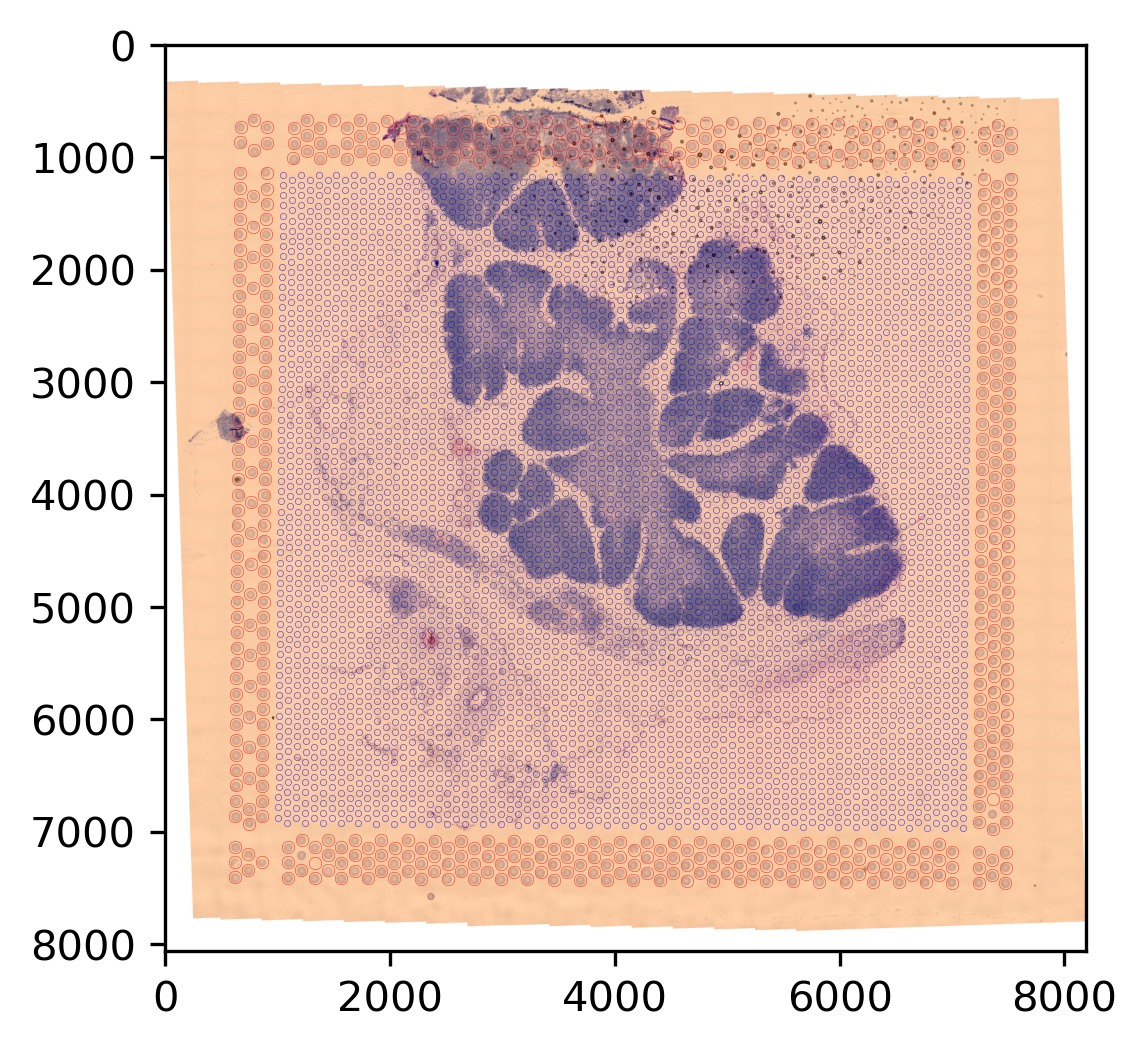

In [11]:
f = files[0] # selected 1st file, can use a "for loop" for multiple files -> for f in files:
# registration
Sensitivity = 1.5
SSMTTarget, LSMTTarget, PixelsPerMicrons,MaxDimentions = VisiumRegistrationWithCellpose(Path,f,RefPath,Sensitivity)

In [12]:
# scale factor json file 
GenerateScaleFactor(Path+'/Output/'+f[:-4]+'/spatial',PixelsPerMicrons,MaxDimentions)

185
              Barcode  UnderTissue  Col  Row            X            Y
0  ACGCCTGACACGCGCT-1          0.0  0.0  0.0  6965.932231  7095.288445
1  TACCGATCCAACACTT-1          0.0  1.0  1.0  6919.943746  7016.543706
2  ATTAAAGCGGACGAGC-1          0.0  0.0  2.0  6875.134154  7095.961314
3  GATAAGGGACGATTAG-1          0.0  1.0  3.0  6829.145669  7017.216575
4  GTGCAAATCACCAATA-1          0.0  0.0  4.0  6784.336077  7096.634183


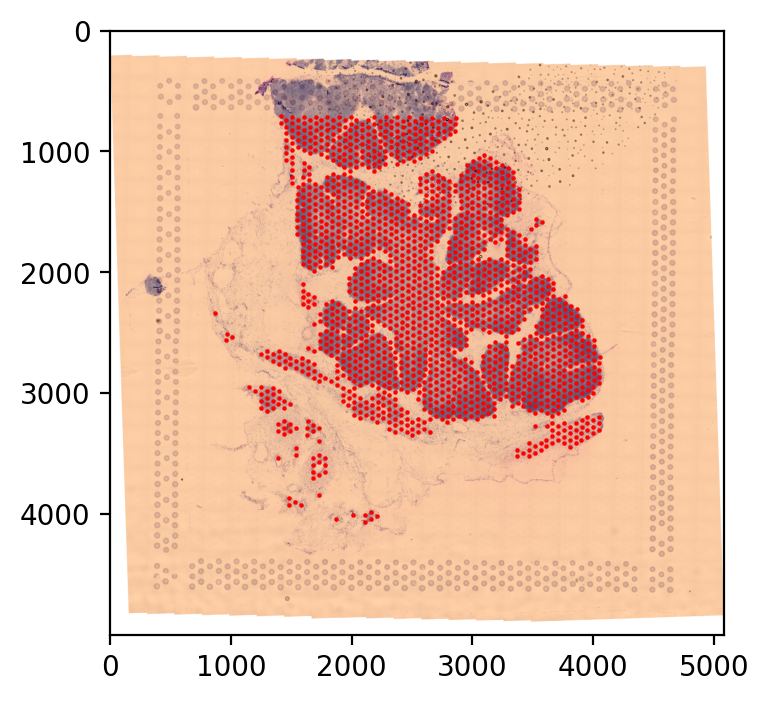

In [31]:
# tissue detection
IntThreshold = 185 # recomended 150-220 for tissue detection. go higher to include more background
BarcodeTo_XY = DetectTissue(Path,RefPath,f,IntThreshold,spot_rad=1)